In [1]:
#install tf_geometric
!pip install -U tf_geometric

     |████████████████████████████████| 57 kB 1.8 MB/s  eta 0:00:01
  Created wheel for tf-geometric: filename=tf_geometric-0.0.85-py3-none-any.whl size=83363 sha256=eec7b148374024db939f8d9a79bf444131b3c03d3f8faab390d5f5cdecbc320d
  Stored in directory: /root/.cache/pip/wheels/69/52/e3/73712d9cc745cef103f1c8af7227b2cd6d85afc872d683c777
  Created wheel for ogb-lite: filename=ogb_lite-0.0.3-py3-none-any.whl size=33524 sha256=f4a851bbcb4a403ac798960b0ad4babc66b0b3a3e98cde02453899a5d0140639
  Stored in directory: /root/.cache/pip/wheels/bb/98/b1/5d034ba69940a93aa9b8e05f6e2f630f47b045209bc3cfa210
  Created wheel for tf-sparse: filename=tf_sparse-0.0.12-py3-none-any.whl size=8620 sha256=ed473a96b5d177ccd22787aba1d0a49d39004e231c4209d796d89255efd08198
  Stored in directory: /root/.cache/pip/wheels/2e/41/8f/1e133789167b6af81bb69db1407b7cd05f1d68061f581d8142
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7048 sha256=e233313a702815bc865c9e713936c2cebb6560f16163

In [9]:
## Tensorflow
import tensorflow as tf
import tf_geometric as tfg
import networkx as nx

In [10]:
# a graph with 4 nodes
edge_list1 = [
              [0, 1, 1, 1, 2, 2, 3, 3], # Source Nodes
              [1, 0, 2, 3, 1, 3, 1, 2]  # Target Nodes
            ]
# define the edges for the nodes. edge_list creates a list of tuples of (Source Nodes, Target Nodes) format using edge_list1
# edge_list = [(0,1),(0,2),(0,3),(1,0),(2,0),(2,3),(3,2),(3,0)]

edge_list = list(map(lambda x, y:(x,y), edge_list1[0], edge_list1[1]))

# 6 Features for each node (4x6 - Number of nodes x NUmber of features)

node_features = [
                  [0,1], # Features of Node 0
                  [2,3], # Features of Node 1
                  [4,5], # Features of Node 2
                  [6,7], # Features of Node 3
                ]

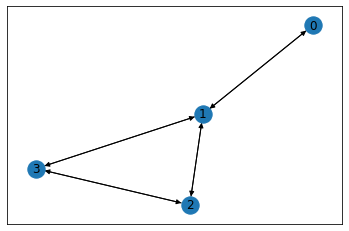

In [11]:
# Make a graph instance to store graph informaiton 
graph =tfg.Graph(x=node_features, edge_index=edge_list)

" Plot the graph "
# This graph has directed edges, therefore use 'nx.DiGraph()' for undirected edges use 'nx.Graph()'

G = nx.DiGraph()
G.add_nodes_from(range(0,graph.num_nodes))
G.add_edges_from(graph.edge_index)
nx.draw_networkx(G)


# Our first convolution

The convolution to be implemented, based on th GCN-Filter: Simplified Cheby-Filter involving 1-Hop Neighbors
![Convolution](./convolution.png)

where g can be any arbitrary activation function (for simplicity we will skip the activation function)

In [20]:
# Create a tensor with values from 0-7
node_feature = tf.range(8, dtype=tf.float32)

#Reshape the tensor in [1,4,2] format
node_features = tf.reshape(node_feature,[1,4,2])

adj_matrix = tf.constant([[[1, 1, 0, 0],
                            [1, 1, 1, 1],
                            [0, 1, 1, 1],
                            [0, 1, 1, 1]]], dtype=tf.float32)

print("Node features:\n", node_features)
print("\nAdjacency matrix:\n", adj_matrix)

Node features:
 tf.Tensor(
[[[0. 1.]
  [2. 3.]
  [4. 5.]
  [6. 7.]]], shape=(1, 4, 2), dtype=float32)

Adjacency matrix:
 tf.Tensor(
[[[1. 1. 0. 0.]
  [1. 1. 1. 1.]
  [0. 1. 1. 1.]
  [0. 1. 1. 1.]]], shape=(1, 4, 4), dtype=float32)


In [21]:
## Source: https://github.com/CrawlScript/tf_geometric
class SimpleConvolution(tf.keras.Model): 

    def __init__(self, c_in, c_out):
        super().__init__()

        #Pytorch nn.linear implementation in Tensorflow 
        initializer = tf.keras.initializers.Identity() # keras initialization of the identity matrix as initial weights.
        self.projection = tf.keras.layers.Dense(c_out, input_shape=(c_in,), activation=None,kernel_initializer=initializer) ##  y=xAT+b

    def call(self, inputs):
        node_features, adj_matrix = inputs
        """
        Inputs:
            node_features - Tensor with node features of shape [batch_size, num_nodes, c_in]
            adj_matrix - Batch of adjacency matrices of the graph. If there is an edge from i to j, adj_matrix[b,i,j]=1 else 0.
                         Supports directed edges by non-symmetric matrices. Assumes to already have added the identity connections.
                         Shape: [batch_size, num_nodes, num_nodes]
        """
        # Num neighbours = number of incoming edges
        num_neighbours = tf.reduce_sum(adj_matrix,axis=2,keepdims=True)
        print("Number of neighbors per node:", num_neighbours.numpy())
        
        # Matrix multiplication between A (Adjacent Matrix) and B (node features)
        node_features = self.projection(node_features) ## HW
        node_features = tf.matmul(adj_matrix, node_features)
        node_features = node_features/ num_neighbours
        return node_features


In [22]:
layer = SimpleConvolution(c_in=2, c_out=2)
out_features = layer([node_features, adj_matrix])

print("Adjacency matrix", adj_matrix.numpy())
print("Input features", node_features.numpy())
print("Output features", out_features.numpy())


Number of neighbors per node: [[[2.]
  [4.]
  [3.]
  [3.]]]
Adjacency matrix [[[1. 1. 0. 0.]
  [1. 1. 1. 1.]
  [0. 1. 1. 1.]
  [0. 1. 1. 1.]]]
Input features [[[0. 1.]
  [2. 3.]
  [4. 5.]
  [6. 7.]]]
Output features [[[1. 2.]
  [3. 4.]
  [4. 5.]
  [4. 5.]]]


## Final remarks

1. This can be seeing as the aggregation of 1-hop neighbors
2. We can stack this type of convolution to aggregate information from k-hop neighbors
3. We need to be careful because k increases the inputs of a node overlap with other nodes, smoothing too much the result